# Set-up

## Imports

In [337]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm

from NMF_iter import functional_norm, normalize_curves
from utils import plot_components, month_to_season

colors = sns.color_palette("deep")
sns.set_theme()
pd.options.mode.chained_assignment = None

## Parameters

In [338]:
n_comp = 5
n_runs = 1000
train_years = ['2021']
test_years = ['2022', '2023']

# arrays_path = f'data/3_output/nmf_results/batch_clean/clean_results_{n_comp}comp_{n_runs}runs.npz'
arrays_path = f"data/3_output/nmf_results/batch_clean/clean_results_{n_comp}comp_{n_runs}runs_{'_'.join(train_years)}.npz"
models_path = arrays_path.replace('.npz', '.pkl')

## Functions

# Main

In [339]:
input_df = pd.read_csv(f"data/2_processed/daily_curves_Italy.csv", index_col=0)
# Convert everything in GWh
input_df = input_df / 1000
pattern = r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$'
unit_info = input_df.index.str.extract(pattern).set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
select_period_train = df.year.isin(train_years)
select_period_test = df.year.isin(test_years)
df = df.loc[select_period_train | select_period_test, :]
unit_info = unit_info.loc[select_period_train | select_period_test, :]
unit_info_train = unit_info.loc[select_period_train, :]
unit_info_test = unit_info.loc[select_period_test, :]
df_train = df.loc[select_period_train, :]
df_test = df.loc[select_period_test, :]
print(len(df_train))
df_train.head(3)

365


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,region,year,month,daytype
Italy_2021-01-01_Holiday,24.375000,23.142999,21.418001,20.136000,19.257999,19.473999,20.382000,21.137000,21.204001,22.809999,...,29.969001,30.031000,28.681,27.158999,24.913000,22.807000,Italy,2021,01,Holiday
Italy_2021-01-02_Saturday,22.807000,21.146000,20.085000,19.431001,19.543000,20.095000,22.104000,23.960001,25.809999,28.031999,...,35.500001,34.347000,31.864,29.392999,26.308999,23.326001,Italy,2021,01,Saturday
Italy_2021-01-03_Holiday,23.326001,21.322000,20.397999,19.543001,19.229000,19.879000,21.032999,22.168000,23.240000,25.000999,...,32.783000,32.547001,30.280,28.256999,25.917000,23.235001,Italy,2021,01,Holiday


In [340]:
# Load the arrays from the .npz file
data = np.load(arrays_path)
with open(models_path, 'rb') as file:
    models = pickle.load(file)
# Access the arrays
H_results = data['H_results']
W_results = data['W_results']
iterations = data['iterations']
loss_nmf = data['loss_nmf']
loss_constraint = data['loss_constraint']

n_runs = H_results.shape[-1]

In [341]:
X_unnorm_train = df_train.drop(unit_info_train.columns, axis=1)
X_unnorm_test = df_test.drop(unit_info_test.columns, axis=1)
X_unnorm_train_test = pd.concat([X_unnorm_train, X_unnorm_test])

unit_info_train_test = pd.concat([unit_info_train, unit_info_test])

h = 24 / (X_unnorm_train_test.shape[1]-1)

norm_X_train_test = X_unnorm_train_test.apply(lambda row: functional_norm(row, h), axis=1, raw=True)
norm_X_train = norm_X_train_test[unit_info_train_test.year.isin(train_years)]
norm_X_test = norm_X_train_test[unit_info_train_test.year.isin(test_years)]

curves_comp = {}

X_test = df_test.drop(unit_info_test.columns, axis=1)
X_test = normalize_curves(X_test)

for k in range(H_results.shape[0]):

    df_list = []

    for b in tqdm(range(n_runs)):

        model = models[b]
        H = model.components_
        W_train = W_results[..., b]
        W_test = model.transform(X_test)

        W = np.vstack((W_train, W_test))

        W_k = W[:, k]
        H_k = H[k, :]

        # HOTFIX: Normalize the rows of H
        H_k = H_k / functional_norm(H_k, h)

        curves_k = (norm_X_train_test * W_k).values.reshape((len(norm_X_train_test), 1)).dot(H_k.reshape((1, H_k.shape[0])))
        # We squeeze the last point corresponding to hour 24:00 of day d because it is at the same moment of 00:00 of day d+1 and we want a unique value per time instant
        curves_k = pd.DataFrame(curves_k[:,:-1], columns=X_unnorm_train_test.columns[:-1], index=X_unnorm_train_test.index)
        curves_k['date'] = curves_k.index.str.split('_').str[1]
        curves_k = pd.concat([curves_k, unit_info_train_test], axis=1)

        curves_k['run'] = b

        df_list.append(curves_k)

    
    curves_comp[f'Component {k + 1}'] = pd.concat(df_list).sort_values('date') # Sort to recover the time order

curves_comp['Component 1']

100%|██████████| 271/271 [00:36<00:00,  7.46it/s]


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,date,region,year,month,daytype,run
Italy_2021-01-01_Holiday,3.155008,2.808496,2.592716,2.461107,2.490856,2.781556,3.809492,4.595765,4.669520,5.471612,...,7.369435,6.064498,5.396595,4.685917,2021-01-01,Italy,2021,01,Holiday,0
Italy_2021-01-01_Holiday,1.171622,1.020984,0.979897,0.981108,1.063055,1.312091,2.215951,2.967413,3.208920,3.577194,...,4.131982,3.151554,2.568439,2.112266,2021-01-01,Italy,2021,01,Holiday,213
Italy_2021-01-01_Holiday,1.476429,1.270056,1.221876,1.228674,1.328208,1.619162,2.665501,3.422308,3.582618,3.966799,...,4.921599,3.627058,2.883163,2.300710,2021-01-01,Italy,2021,01,Holiday,210
Italy_2021-01-01_Holiday,4.087746,3.764382,3.576586,3.436655,3.422157,3.647118,4.209014,4.783918,5.500324,6.409856,...,8.133166,8.173577,7.757202,7.127091,2021-01-01,Italy,2021,01,Holiday,224
Italy_2021-01-01_Holiday,2.295808,2.132332,1.963226,1.823361,1.801598,2.018054,2.805699,3.848281,4.357968,5.135009,...,5.535886,5.154588,4.898795,4.535897,2021-01-01,Italy,2021,01,Holiday,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Italy_2023-12-31_Holiday,3.408630,3.024115,2.891071,2.851576,2.989864,3.479325,5.145853,6.490040,6.987593,7.849145,...,9.599805,7.834575,6.685542,5.675028,2023-12-31,Italy,2023,12,Holiday,122
Italy_2023-12-31_Holiday,1.300327,1.147757,1.177098,1.260434,1.442592,1.904713,3.544510,5.196419,6.014702,6.440627,...,6.095638,4.635861,3.605613,2.906400,2023-12-31,Italy,2023,12,Holiday,153
Italy_2023-12-31_Holiday,2.147897,1.970639,1.937465,1.952615,2.089053,2.558544,4.176812,5.976465,7.056734,7.750692,...,7.438136,6.369282,5.457454,4.744599,2023-12-31,Italy,2023,12,Holiday,136
Italy_2023-12-31_Holiday,5.309321,4.744060,4.484401,4.395014,4.467908,4.766518,5.852586,6.558853,6.470625,7.048383,...,9.036669,6.935087,5.852109,4.904477,2023-12-31,Italy,2023,12,Holiday,14


In [342]:
info_cols = ['region', 'year', 'month', 'daytype', 'date', 'run']

comp_df = curves_comp['Component 1'].melt(id_vars=info_cols, var_name='hour', value_name='Component 1')

for k in tqdm(range(1, H.shape[0])):
    comp = f'Component {k + 1}'
    comp_df[comp] = curves_comp[comp].melt(id_vars=info_cols, var_name='hour', value_name='load')['load']

comp_df['date'] = pd.to_datetime(comp_df['date'])
comp_df['hour'] = comp_df.hour.astype(float)
comp_df['datetime'] = comp_df['date'] + pd.to_timedelta(comp_df['hour'], unit='h')
comp_df.set_index('datetime', inplace=True)
comp_df.sort_values(['region', 'date', 'hour', 'run'], inplace=True)
comp_df

100%|██████████| 4/4 [00:06<00:00,  1.62s/it]


,region,year,month,daytype,date,run,hour,Component 1,Component 2,Component 3,Component 4,Component 5
datetime,,,,,,,,,,,,
2021-01-01 00:00:00,Italy,2021,01,Holiday,2021-01-01,0,0.0,3.155008,10.543265,0.777136,1.536844,4.803459
2021-01-01 00:00:00,Italy,2021,01,Holiday,2021-01-01,1,0.0,1.115404,9.799376,1.830566,3.514373,4.039177
2021-01-01 00:00:00,Italy,2021,01,Holiday,2021-01-01,2,0.0,2.789852,3.966244,0.163581,12.034907,1.713101
2021-01-01 00:00:00,Italy,2021,01,Holiday,2021-01-01,3,0.0,11.509200,3.107124,1.674613,2.392674,0.969816
2021-01-01 00:00:00,Italy,2021,01,Holiday,2021-01-01,4,0.0,1.020495,3.823974,0.395852,8.772060,6.846808
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 23:00:00,Italy,2023,12,Holiday,2023-12-31,266,23.0,4.586278,7.064066,0.718530,2.410315,5.732457
2023-12-31 23:00:00,Italy,2023,12,Holiday,2023-12-31,267,23.0,3.104632,6.941331,0.367030,1.085703,8.084214
2023-12-31 23:00:00,Italy,2023,12,Holiday,2023-12-31,268,23.0,4.315312,6.901946,0.795977,2.135821,6.542377


In [343]:
comp_cols = [f'Component {k+1}' for k in range(H.shape[0])]
day_df = comp_df.groupby(['region', 'year', 'month', 'date', 'daytype', 'run'], as_index=False, sort=False)[comp_cols].sum()
day_df.loc[:, comp_cols] = day_df.loc[:, comp_cols] * h # Correct for the window size
day_df

,region,year,month,date,daytype,run,Component 1,Component 2,Component 3,Component 4,Component 5
0,Italy,2021,01,2021-01-01,Holiday,0,133.668523,193.493695,31.223116,38.683320,111.909913
1,Italy,2021,01,2021-01-01,Holiday,1,34.697057,146.107834,61.974173,156.544093,121.451809
2,Italy,2021,01,2021-01-01,Holiday,2,139.385159,112.427393,6.230288,211.753529,41.581814
3,Italy,2021,01,2021-01-01,Holiday,3,268.201784,43.341361,67.707270,66.783113,52.354801
4,Italy,2021,01,2021-01-01,Holiday,4,34.178883,70.960887,16.468367,175.278698,217.617623
...,...,...,...,...,...,...,...,...,...,...,...
296740,Italy,2023,12,2023-12-31,Holiday,266,140.101052,122.799140,19.654587,76.281396,150.351672
296741,Italy,2023,12,2023-12-31,Holiday,267,111.075423,129.184905,10.589692,26.851451,215.793159
296742,Italy,2023,12,2023-12-31,Holiday,268,139.194848,123.317353,22.468033,62.140179,167.680441
296743,Italy,2023,12,2023-12-31,Holiday,269,175.924773,116.972386,37.581372,56.847973,135.865585


In [344]:
month_df = day_df.groupby(['region', 'year', 'month', 'run'], as_index=False, sort=False)[[f'Component {k+1}' for k in range(H.shape[0])]].sum()
month_df

,region,year,month,run,Component 1,Component 2,Component 3,Component 4,Component 5
0,Italy,2021,01,0,4428.516750,2477.897075,11686.916192,5319.405405,2589.086619
1,Italy,2021,01,1,4428.198937,2517.441620,11693.586703,5378.722249,2485.431038
2,Italy,2021,01,2,4325.223145,2555.878266,11713.930294,2826.533578,5100.035582
3,Italy,2021,01,3,4509.224142,2378.465605,11681.360854,2183.786561,5717.137314
4,Italy,2021,01,4,4410.481957,2530.871124,11651.836410,2682.555448,5157.409252
...,...,...,...,...,...,...,...,...,...
9751,Italy,2023,12,266,3969.863867,2098.942306,10376.689806,4712.828108,2995.241520
9752,Italy,2023,12,267,3801.208464,2306.655799,10913.664700,3062.434482,4095.280589
9753,Italy,2023,12,268,3871.901432,2191.909329,10706.418450,4428.562055,3156.885819
9754,Italy,2023,12,269,3805.761641,2283.068033,10235.774828,4796.347717,3021.992829


In [345]:
year_df = month_df.groupby(['region', 'year', 'run'], as_index=False)[[f'Component {k+1}' for k in range(H.shape[0])]].sum()
year_df

,region,year,run,Component 1,Component 2,Component 3,Component 4,Component 5
0,Italy,2021,0,32908.352791,37946.571749,150071.443295,52215.384118,44918.530663
1,Italy,2021,1,35516.537966,35948.794431,150695.041299,49590.175151,46466.426269
2,Italy,2021,2,37715.869079,32828.942531,150328.433913,50269.831763,47029.880411
3,Italy,2021,3,36842.823800,34446.860982,149995.540849,50170.827455,46510.951107
4,Italy,2021,4,35784.496365,35616.457093,150112.722456,48804.001899,47800.764584
...,...,...,...,...,...,...,...,...
808,Italy,2023,266,31266.859657,32932.332919,149192.419682,50706.393529,45105.479247
809,Italy,2023,267,30656.351811,36037.927468,154568.323427,47146.597987,42047.119114
810,Italy,2023,268,29269.219043,34468.863678,149198.664863,51475.182083,44505.337921
811,Italy,2023,269,29711.157429,34495.911590,144720.264139,52516.745570,46195.032465


In [346]:
# Y_train = pd.read_pickle('data/2_processed/PenNMF/Y_{}.pkl'.format('_'.join(train_years)))
# Y_test = pd.read_pickle('data/2_processed/PenNMF/Y_{}.pkl'.format('_'.join(test_years)))
# Y = pd.concat([Y_train, Y_test], axis=0).sort_index()
Y = pd.read_pickle('data/2_processed/PenNMF/Y.pkl')
Y

,Domestico,Industria,Servizi
Mese,,,
2020-01-01,6441.363317,11825.246197,8576.812874
2020-02-01,5598.346084,12649.510509,7741.532495
2020-03-01,6210.310908,10390.997313,6427.915271
2020-04-01,5510.646455,8373.048886,5204.526162
2020-05-01,5185.758162,12145.381439,6262.037750
2020-06-01,5043.203018,12189.245865,7427.909331
2020-07-01,6104.410642,13087.043126,9516.201639
2020-08-01,6627.809387,8396.219017,9374.003993
2020-09-01,5206.096122,12898.246109,8512.639969


In [347]:
Y_pred = month_df.copy()
Y_pred['Domestico'] = Y_pred['Component 1'] + Y_pred['Component 2']
Y_pred['Industria'] = Y_pred['Component 3']
Y_pred['Servizi'] = Y_pred['Component 4'] + Y_pred['Component 5']
Y_pred.drop(columns=[f'Component {k+1}' for k in range(n_comp)], inplace=True)
Y_pred = Y_pred.groupby(['year', 'month', 'run'], as_index=False).sum().drop('region', axis=1)
Y_pred['date'] = pd.to_datetime(Y_pred['year'].astype(str) + '-' + Y_pred['month'], format='%Y-%m')
Y_pred.drop(columns=['year', 'month'], inplace=True)
# Set the 'date' column as the index
Y_pred.set_index('date', inplace=True)
Y_pred

,run,Domestico,Industria,Servizi
date,,,,
2021-01-01,0,6906.413825,11686.916192,7908.492024
2021-01-01,1,6945.640557,11693.586703,7864.153288
2021-01-01,2,6881.101411,11713.930294,7926.569161
2021-01-01,3,6887.689747,11681.360854,7900.923875
2021-01-01,4,6941.353080,11651.836410,7839.964700
...,...,...,...,...
2023-12-01,266,6068.806173,10376.689806,7708.069628
2023-12-01,267,6107.864262,10913.664700,7157.715071
2023-12-01,268,6063.810761,10706.418450,7585.447874


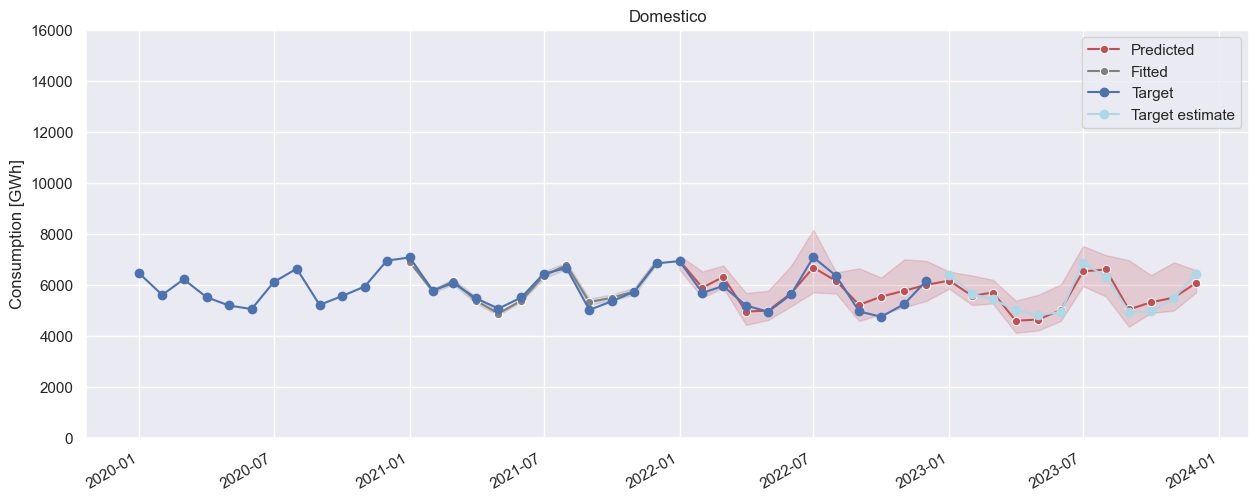

In [348]:
# Define the sector to plot
sector = 'Domestico'

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(
    data=Y_pred[Y_pred.index.year.astype(str).isin(test_years)].reset_index(),
    x='date',
    y=sector,
    color=colors[3],
    label='Predicted',
    errorbar='pi',
    ax=ax,
    marker='o'
)

sns.lineplot(
    data=Y_pred[Y_pred.index.year.astype(str).isin(train_years)].reset_index(),
    x='date',
    y=sector,
    color='grey',
    label='Fitted',
    errorbar='pi',
    ax=ax,
    marker='o'
)

Y.loc[Y.index.year < 2023, sector].plot(marker='o', color=colors[0], label='Target', ax=ax)
Y.loc[Y.index.year == 2023, sector].plot(marker='o', color='lightblue', label='Target estimate', ax=ax)

# Customize the plot
ax.set_ylim((0, 16000))
ax.set_ylabel('Consumption [GWh]')
ax.set_xlabel(None)
ax.set_title(sector)
ax.legend()

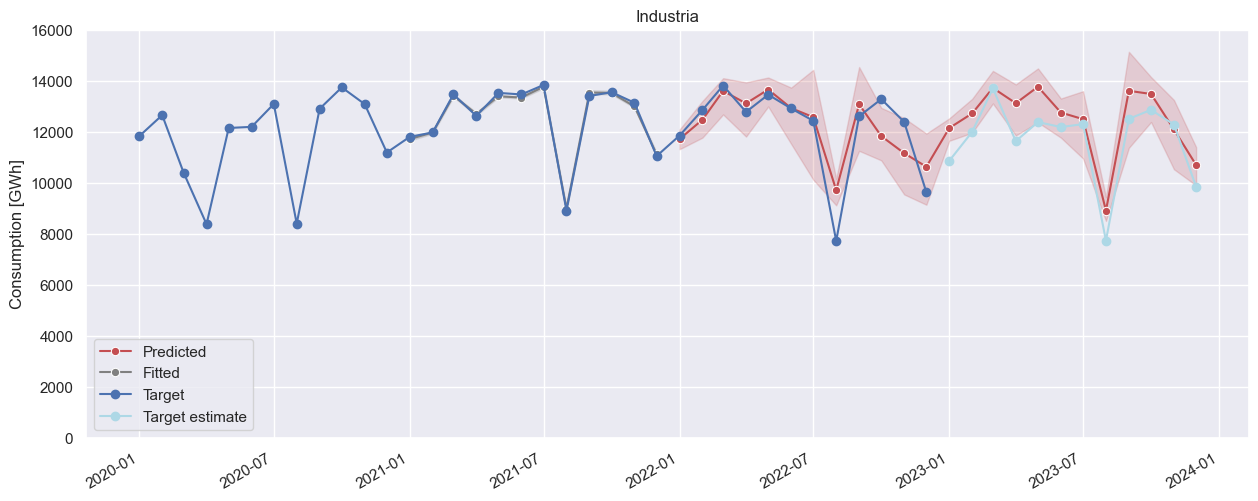

In [349]:
# Define the sector to plot
sector = 'Industria'

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(
    data=Y_pred[Y_pred.index.year.astype(str).isin(test_years)].reset_index(),
    x='date',
    y=sector,
    color=colors[3],
    label='Predicted',
    errorbar='pi',
    ax=ax,
    marker='o'
)

sns.lineplot(
    data=Y_pred[Y_pred.index.year.astype(str).isin(train_years)].reset_index(),
    x='date',
    y=sector,
    color='grey',
    label='Fitted',
    errorbar='pi',
    ax=ax,
    marker='o'
)

# Plot the target data using pandas' plot method
Y.loc[Y.index.year < 2023, sector].plot(marker='o', color=colors[0], label='Target', ax=ax)
# Plot the target data using pandas' plot method
Y.loc[Y.index.year == 2023, sector].plot(marker='o', color='lightblue', label='Target estimate', ax=ax)

# Customize the plot
ax.set_ylim((0, 16000))
ax.set_ylabel('Consumption [GWh]')
ax.set_xlabel(None)
ax.set_title(sector)
ax.legend()

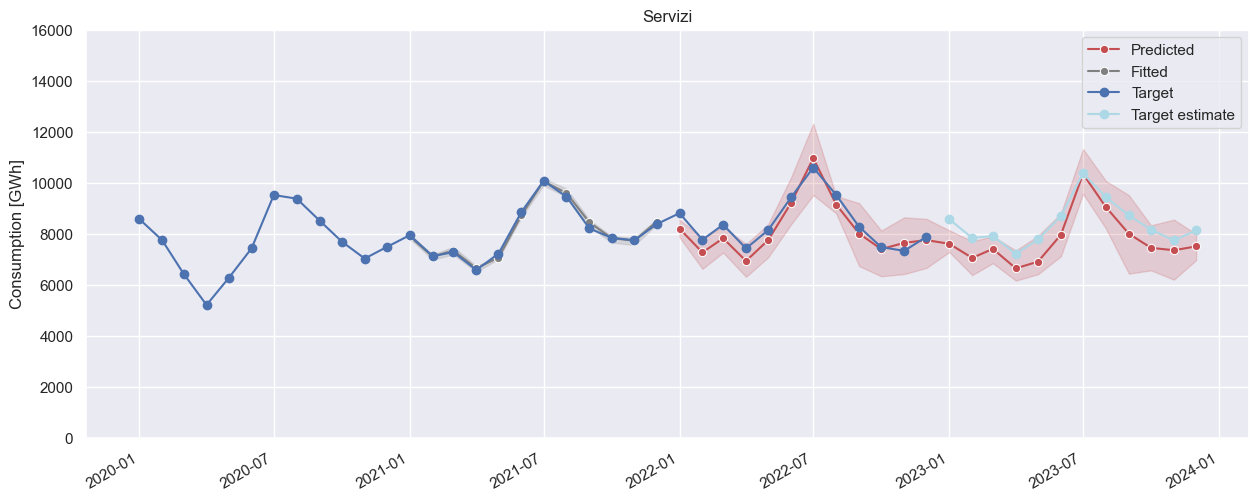

In [350]:
# Define the sector to plot
sector = 'Servizi'

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(
    data=Y_pred[Y_pred.index.year.astype(str).isin(test_years)].reset_index(),
    x='date',
    y=sector,
    color=colors[3],
    label='Predicted',
    errorbar='pi',
    ax=ax,
    marker='o'
)

sns.lineplot(
    data=Y_pred[Y_pred.index.year.astype(str).isin(train_years)].reset_index(),
    x='date',
    y=sector,
    color='grey',
    label='Fitted',
    errorbar='pi',
    ax=ax,
    marker='o'
)

# Plot the target data using pandas' plot method
Y.loc[Y.index.year < 2023, sector].plot(marker='o', color=colors[0], label='Target', ax=ax)
# Plot the target data using pandas' plot method
Y.loc[Y.index.year == 2023, sector].plot(marker='o', color='lightblue', label='Target estimate', ax=ax)

# Customize the plot
ax.set_ylim((0, 16000))
ax.set_ylabel('Consumption [GWh]')
ax.set_xlabel(None)
ax.set_title(sector)
ax.legend()

In [312]:
Y_pred.to_pickle('data/3_output/month_pred/Y_pred_train_{}_test_{}.pkl'.format('_'.join(train_years), '_'.join(test_years)))

<HR>

# Tests

In [351]:
curves_comp['Component 1']

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,date,region,year,month,daytype,run
Italy_2021-01-01_Holiday,3.155008,2.808496,2.592716,2.461107,2.490856,2.781556,3.809492,4.595765,4.669520,5.471612,...,7.369435,6.064498,5.396595,4.685917,2021-01-01,Italy,2021,01,Holiday,0
Italy_2021-01-01_Holiday,1.171622,1.020984,0.979897,0.981108,1.063055,1.312091,2.215951,2.967413,3.208920,3.577194,...,4.131982,3.151554,2.568439,2.112266,2021-01-01,Italy,2021,01,Holiday,213
Italy_2021-01-01_Holiday,1.476429,1.270056,1.221876,1.228674,1.328208,1.619162,2.665501,3.422308,3.582618,3.966799,...,4.921599,3.627058,2.883163,2.300710,2021-01-01,Italy,2021,01,Holiday,210
Italy_2021-01-01_Holiday,4.087746,3.764382,3.576586,3.436655,3.422157,3.647118,4.209014,4.783918,5.500324,6.409856,...,8.133166,8.173577,7.757202,7.127091,2021-01-01,Italy,2021,01,Holiday,224
Italy_2021-01-01_Holiday,2.295808,2.132332,1.963226,1.823361,1.801598,2.018054,2.805699,3.848281,4.357968,5.135009,...,5.535886,5.154588,4.898795,4.535897,2021-01-01,Italy,2021,01,Holiday,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Italy_2023-12-31_Holiday,3.408630,3.024115,2.891071,2.851576,2.989864,3.479325,5.145853,6.490040,6.987593,7.849145,...,9.599805,7.834575,6.685542,5.675028,2023-12-31,Italy,2023,12,Holiday,122
Italy_2023-12-31_Holiday,1.300327,1.147757,1.177098,1.260434,1.442592,1.904713,3.544510,5.196419,6.014702,6.440627,...,6.095638,4.635861,3.605613,2.906400,2023-12-31,Italy,2023,12,Holiday,153
Italy_2023-12-31_Holiday,2.147897,1.970639,1.937465,1.952615,2.089053,2.558544,4.176812,5.976465,7.056734,7.750692,...,7.438136,6.369282,5.457454,4.744599,2023-12-31,Italy,2023,12,Holiday,136
Italy_2023-12-31_Holiday,5.309321,4.744060,4.484401,4.395014,4.467908,4.766518,5.852586,6.558853,6.470625,7.048383,...,9.036669,6.935087,5.852109,4.904477,2023-12-31,Italy,2023,12,Holiday,14


In [352]:
comp_df

,region,year,month,daytype,date,run,hour,Component 1,Component 2,Component 3,Component 4,Component 5
datetime,,,,,,,,,,,,
2021-01-01 00:00:00,Italy,2021,01,Holiday,2021-01-01,0,0.0,3.155008,10.543265,0.777136,1.536844,4.803459
2021-01-01 00:00:00,Italy,2021,01,Holiday,2021-01-01,1,0.0,1.115404,9.799376,1.830566,3.514373,4.039177
2021-01-01 00:00:00,Italy,2021,01,Holiday,2021-01-01,2,0.0,2.789852,3.966244,0.163581,12.034907,1.713101
2021-01-01 00:00:00,Italy,2021,01,Holiday,2021-01-01,3,0.0,11.509200,3.107124,1.674613,2.392674,0.969816
2021-01-01 00:00:00,Italy,2021,01,Holiday,2021-01-01,4,0.0,1.020495,3.823974,0.395852,8.772060,6.846808
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 23:00:00,Italy,2023,12,Holiday,2023-12-31,266,23.0,4.586278,7.064066,0.718530,2.410315,5.732457
2023-12-31 23:00:00,Italy,2023,12,Holiday,2023-12-31,267,23.0,3.104632,6.941331,0.367030,1.085703,8.084214
2023-12-31 23:00:00,Italy,2023,12,Holiday,2023-12-31,268,23.0,4.315312,6.901946,0.795977,2.135821,6.542377


In [353]:
comp_df['Domestico'] = comp_df['Component 1'] + comp_df['Component 2']
comp_df['Industria'] = comp_df['Component 3']
comp_df['Servizi'] = comp_df['Component 4'] + comp_df['Component 5']

In [354]:
comp_df

,region,year,month,daytype,date,run,hour,Component 1,Component 2,Component 3,Component 4,Component 5,Domestico,Industria,Servizi
datetime,,,,,,,,,,,,,,,
2021-01-01 00:00:00,Italy,2021,01,Holiday,2021-01-01,0,0.0,3.155008,10.543265,0.777136,1.536844,4.803459,13.698274,0.777136,6.340303
2021-01-01 00:00:00,Italy,2021,01,Holiday,2021-01-01,1,0.0,1.115404,9.799376,1.830566,3.514373,4.039177,10.914780,1.830566,7.553550
2021-01-01 00:00:00,Italy,2021,01,Holiday,2021-01-01,2,0.0,2.789852,3.966244,0.163581,12.034907,1.713101,6.756096,0.163581,13.748008
2021-01-01 00:00:00,Italy,2021,01,Holiday,2021-01-01,3,0.0,11.509200,3.107124,1.674613,2.392674,0.969816,14.616324,1.674613,3.362490
2021-01-01 00:00:00,Italy,2021,01,Holiday,2021-01-01,4,0.0,1.020495,3.823974,0.395852,8.772060,6.846808,4.844469,0.395852,15.618868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 23:00:00,Italy,2023,12,Holiday,2023-12-31,266,23.0,4.586278,7.064066,0.718530,2.410315,5.732457,11.650344,0.718530,8.142772
2023-12-31 23:00:00,Italy,2023,12,Holiday,2023-12-31,267,23.0,3.104632,6.941331,0.367030,1.085703,8.084214,10.045963,0.367030,9.169917
2023-12-31 23:00:00,Italy,2023,12,Holiday,2023-12-31,268,23.0,4.315312,6.901946,0.795977,2.135821,6.542377,11.217259,0.795977,8.678198


In [355]:
tot_cons = comp_df.groupby(['date', 'run'], as_index=False)[['Domestico', 'Industria', 'Servizi']].sum()
tot_cons = comp_df[['date', 'run']].merge(tot_cons, on=['date', 'run'], how='left')
tot_cons.index = comp_df.index
tot_cons

,date,run,Domestico,Industria,Servizi
datetime,,,,,
2021-01-01 00:00:00,2021-01-01,0,327.162218,31.223116,150.593233
2021-01-01 00:00:00,2021-01-01,1,180.804890,61.974173,277.995902
2021-01-01 00:00:00,2021-01-01,2,251.812552,6.230288,253.335343
2021-01-01 00:00:00,2021-01-01,3,311.543145,67.707270,119.137914
2021-01-01 00:00:00,2021-01-01,4,105.139770,16.468367,392.896320
...,...,...,...,...,...
2023-12-31 23:00:00,2023-12-31,266,262.900192,19.654587,226.633068
2023-12-31 23:00:00,2023-12-31,267,240.260327,10.589692,242.644610
2023-12-31 23:00:00,2023-12-31,268,262.512202,22.468033,229.820620


In [356]:
for sector in ['Domestico', 'Industria', 'Servizi']:
    comp_df[sector] /= tot_cons[sector]
comp_df

,region,year,month,daytype,date,run,hour,Component 1,Component 2,Component 3,Component 4,Component 5,Domestico,Industria,Servizi
datetime,,,,,,,,,,,,,,,
2021-01-01 00:00:00,Italy,2021,01,Holiday,2021-01-01,0,0.0,3.155008,10.543265,0.777136,1.536844,4.803459,0.041870,0.024890,0.042102
2021-01-01 00:00:00,Italy,2021,01,Holiday,2021-01-01,1,0.0,1.115404,9.799376,1.830566,3.514373,4.039177,0.060368,0.029538,0.027171
2021-01-01 00:00:00,Italy,2021,01,Holiday,2021-01-01,2,0.0,2.789852,3.966244,0.163581,12.034907,1.713101,0.026830,0.026256,0.054268
2021-01-01 00:00:00,Italy,2021,01,Holiday,2021-01-01,3,0.0,11.509200,3.107124,1.674613,2.392674,0.969816,0.046916,0.024733,0.028224
2021-01-01 00:00:00,Italy,2021,01,Holiday,2021-01-01,4,0.0,1.020495,3.823974,0.395852,8.772060,6.846808,0.046076,0.024037,0.039753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 23:00:00,Italy,2023,12,Holiday,2023-12-31,266,23.0,4.586278,7.064066,0.718530,2.410315,5.732457,0.044315,0.036558,0.035929
2023-12-31 23:00:00,Italy,2023,12,Holiday,2023-12-31,267,23.0,3.104632,6.941331,0.367030,1.085703,8.084214,0.041813,0.034659,0.037792
2023-12-31 23:00:00,Italy,2023,12,Holiday,2023-12-31,268,23.0,4.315312,6.901946,0.795977,2.135821,6.542377,0.042730,0.035427,0.037761


In [357]:
profiles = comp_df.groupby(['year', 'month', 'daytype', 'hour', 'run'], as_index=False)[['Domestico', 'Industria', 'Servizi']].mean()
profiles

,year,month,daytype,hour,run,Domestico,Industria,Servizi
0,2021,01,Holiday,0.0,0,0.040679,0.024890,0.041124
1,2021,01,Holiday,0.0,1,0.055248,0.029538,0.025575
2,2021,01,Holiday,0.0,2,0.027345,0.026256,0.052036
3,2021,01,Holiday,0.0,3,0.047615,0.024733,0.022747
4,2021,01,Holiday,0.0,4,0.039125,0.024037,0.040124
...,...,...,...,...,...,...,...,...
936571,2023,12,Working day,23.0,266,0.035590,0.036558,0.034124
936572,2023,12,Working day,23.0,267,0.033633,0.034659,0.038604
936573,2023,12,Working day,23.0,268,0.034396,0.035427,0.036244
936574,2023,12,Working day,23.0,269,0.036825,0.037039,0.033178


In [358]:
profiles['season'] = profiles.month.astype(int).map(month_to_season)
profiles

,year,month,daytype,hour,run,Domestico,Industria,Servizi,season
0,2021,01,Holiday,0.0,0,0.040679,0.024890,0.041124,Winter
1,2021,01,Holiday,0.0,1,0.055248,0.029538,0.025575,Winter
2,2021,01,Holiday,0.0,2,0.027345,0.026256,0.052036,Winter
3,2021,01,Holiday,0.0,3,0.047615,0.024733,0.022747,Winter
4,2021,01,Holiday,0.0,4,0.039125,0.024037,0.040124,Winter
...,...,...,...,...,...,...,...,...,...
936571,2023,12,Working day,23.0,266,0.035590,0.036558,0.034124,Fall
936572,2023,12,Working day,23.0,267,0.033633,0.034659,0.038604,Fall
936573,2023,12,Working day,23.0,268,0.034396,0.035427,0.036244,Fall
936574,2023,12,Working day,23.0,269,0.036825,0.037039,0.033178,Fall


(0.0, 0.065)

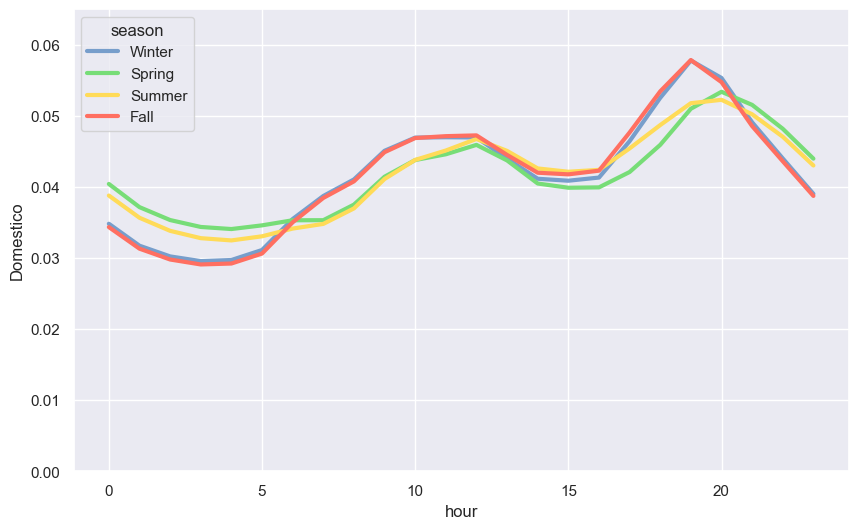

In [365]:
daytype = 'Holiday'
sector = 'Domestico'

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=profiles,
    x='hour',
    y=sector,
    hue='season',
    errorbar=None,
    ax=ax,
    # marker='o',
    linewidth=3,
    palette=['#779ecb', '#77dd77', '#ffdb58', '#ff6f61']
)
ax.set_ylim((0,0.065))

In [366]:
period = ["2022-02-01", "2022-02-07"]
test = comp_df.loc[(comp_df.index >= period[0]) & (comp_df.index <= period[1]), :]
test['Domestico'] = test['Component 1'] + test['Component 2']
test['Industria'] = test['Component 3']
test['Servizi'] = test['Component 4'] + test['Component 5']
test

,region,year,month,daytype,date,run,hour,Component 1,Component 2,Component 3,Component 4,Component 5,Domestico,Industria,Servizi
datetime,,,,,,,,,,,,,,,
2022-02-01,Italy,2022,02,Working day,2022-02-01,0,0.0,2.479835,0.844353,13.324661,9.705260,5.297850,3.324188,13.324661,15.003110
2022-02-01,Italy,2022,02,Working day,2022-02-01,1,0.0,5.317133,3.667642,16.928399,2.773945,3.457055,8.984775,16.928399,6.231000
2022-02-01,Italy,2022,02,Working day,2022-02-01,2,0.0,1.918837,1.366712,16.033358,3.689709,8.632997,3.285549,16.033358,12.322705
2022-02-01,Italy,2022,02,Working day,2022-02-01,3,0.0,1.451506,8.052570,12.712454,5.547774,4.216546,9.504076,12.712454,9.764320
2022-02-01,Italy,2022,02,Working day,2022-02-01,4,0.0,5.227233,6.267217,12.840979,2.410560,3.519489,11.494450,12.840979,5.930049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-07,Italy,2022,02,Monday,2022-02-07,266,0.0,3.216393,2.880393,16.586481,3.759290,1.604457,6.096786,16.586481,5.363747
2022-02-07,Italy,2022,02,Monday,2022-02-07,267,0.0,3.006280,0.848968,11.907669,7.040291,3.311647,3.855247,11.907669,10.351938
2022-02-07,Italy,2022,02,Monday,2022-02-07,268,0.0,2.932737,3.973330,15.540539,3.650401,1.019689,6.906066,15.540539,4.670090


<Axes: xlabel='datetime', ylabel='Servizi'>

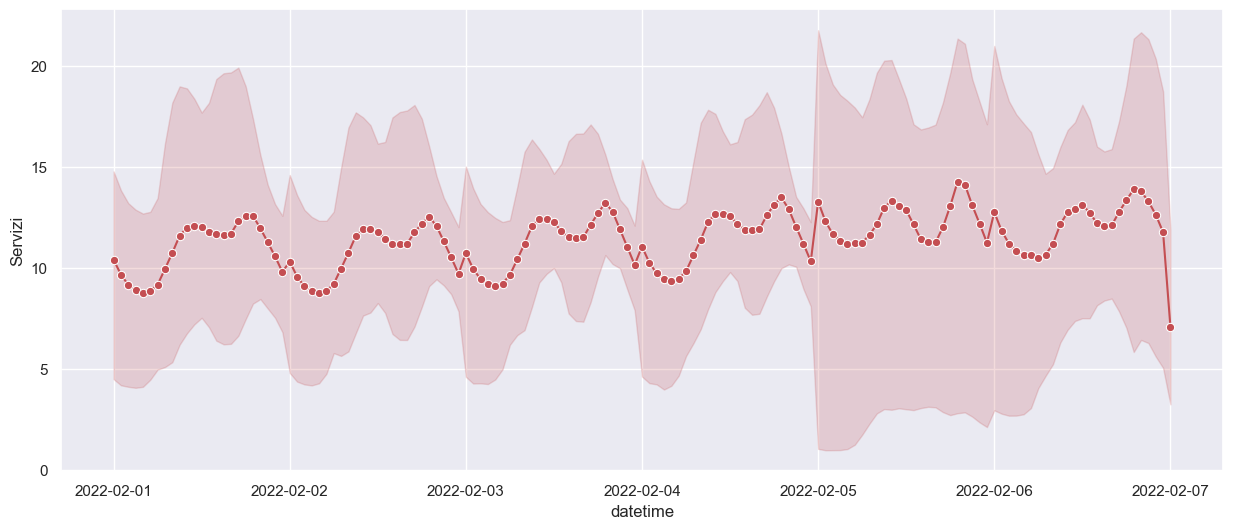

In [369]:
sector = 'Servizi'
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(
    data=test.reset_index(),
    x='datetime',
    y=sector,
    color=colors[3],
    errorbar='pi',
    ax=ax,
    marker='o'
)

In [370]:
test = curves_comp['Component 1']
test

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,date,region,year,month,daytype,run
Italy_2021-01-01_Holiday,3.155008,2.808496,2.592716,2.461107,2.490856,2.781556,3.809492,4.595765,4.669520,5.471612,...,7.369435,6.064498,5.396595,4.685917,2021-01-01,Italy,2021,01,Holiday,0
Italy_2021-01-01_Holiday,1.171622,1.020984,0.979897,0.981108,1.063055,1.312091,2.215951,2.967413,3.208920,3.577194,...,4.131982,3.151554,2.568439,2.112266,2021-01-01,Italy,2021,01,Holiday,213
Italy_2021-01-01_Holiday,1.476429,1.270056,1.221876,1.228674,1.328208,1.619162,2.665501,3.422308,3.582618,3.966799,...,4.921599,3.627058,2.883163,2.300710,2021-01-01,Italy,2021,01,Holiday,210
Italy_2021-01-01_Holiday,4.087746,3.764382,3.576586,3.436655,3.422157,3.647118,4.209014,4.783918,5.500324,6.409856,...,8.133166,8.173577,7.757202,7.127091,2021-01-01,Italy,2021,01,Holiday,224
Italy_2021-01-01_Holiday,2.295808,2.132332,1.963226,1.823361,1.801598,2.018054,2.805699,3.848281,4.357968,5.135009,...,5.535886,5.154588,4.898795,4.535897,2021-01-01,Italy,2021,01,Holiday,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Italy_2023-12-31_Holiday,3.408630,3.024115,2.891071,2.851576,2.989864,3.479325,5.145853,6.490040,6.987593,7.849145,...,9.599805,7.834575,6.685542,5.675028,2023-12-31,Italy,2023,12,Holiday,122
Italy_2023-12-31_Holiday,1.300327,1.147757,1.177098,1.260434,1.442592,1.904713,3.544510,5.196419,6.014702,6.440627,...,6.095638,4.635861,3.605613,2.906400,2023-12-31,Italy,2023,12,Holiday,153
Italy_2023-12-31_Holiday,2.147897,1.970639,1.937465,1.952615,2.089053,2.558544,4.176812,5.976465,7.056734,7.750692,...,7.438136,6.369282,5.457454,4.744599,2023-12-31,Italy,2023,12,Holiday,136
Italy_2023-12-31_Holiday,5.309321,4.744060,4.484401,4.395014,4.467908,4.766518,5.852586,6.558853,6.470625,7.048383,...,9.036669,6.935087,5.852109,4.904477,2023-12-31,Italy,2023,12,Holiday,14


In [371]:
test['totday'] = norm_X
test.sort_values('date')

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,date,region,year,month,daytype,run,totday
Italy_2021-01-01_Holiday,3.155008,2.808496,2.592716,2.461107,2.490856,2.781556,3.809492,4.595765,4.669520,5.471612,...,6.064498,5.396595,4.685917,2021-01-01,Italy,2021,01,Holiday,0,597.368996
Italy_2021-01-01_Holiday,5.407438,4.869319,4.665194,4.600102,4.669638,4.940061,5.793544,6.207338,6.351934,6.930907,...,7.875475,6.846932,5.891431,2021-01-01,Italy,2021,01,Holiday,200,597.368996
Italy_2021-01-01_Holiday,3.294786,2.918153,2.716189,2.602040,2.661899,3.006490,4.235306,5.151070,5.269080,6.072437,...,6.360420,5.538220,4.745632,2021-01-01,Italy,2021,01,Holiday,269,597.368996
Italy_2021-01-01_Holiday,2.789852,2.507863,2.342697,2.239150,2.282011,2.613612,3.739965,4.766120,5.193436,6.048976,...,6.360250,5.719548,5.056224,2021-01-01,Italy,2021,01,Holiday,2,597.368996
Italy_2021-01-01_Holiday,1.552306,1.392278,1.336342,1.343142,1.409135,1.599205,2.338690,3.061208,3.284859,3.457195,...,2.242035,1.707237,1.365522,2021-01-01,Italy,2021,01,Holiday,144,597.368996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Italy_2023-12-31_Holiday,1.629531,1.409408,1.306264,1.264012,1.369464,1.792287,3.349374,4.814051,5.203542,5.937825,...,4.974246,4.143885,3.474978,2023-12-31,Italy,2023,12,Holiday,33,602.807502
Italy_2023-12-31_Holiday,4.810135,4.360097,4.065387,3.854912,3.844313,4.146241,5.125243,5.911078,6.223895,7.313124,...,8.778001,8.109069,7.264702,2023-12-31,Italy,2023,12,Holiday,128,602.807502
Italy_2023-12-31_Holiday,5.249971,4.709853,4.413174,4.309583,4.392057,4.716671,5.995163,7.093073,7.134899,7.737448,...,6.395260,5.315214,4.445259,2023-12-31,Italy,2023,12,Holiday,141,602.807502
Italy_2023-12-31_Holiday,2.530322,2.324839,2.256915,2.246191,2.363425,2.814916,4.369206,6.117311,7.141712,7.877758,...,6.632251,5.753090,5.045058,2023-12-31,Italy,2023,12,Holiday,31,602.807502


In [372]:
daily = day_df.copy()
daily['Domestico'] = daily['Component 1'] + daily['Component 2']
daily['Industria'] = daily['Component 3']
daily['Servizi'] = daily['Component 4'] + daily['Component 5']
daily

,region,year,month,date,daytype,run,Component 1,Component 2,Component 3,Component 4,Component 5,Domestico,Industria,Servizi
0,Italy,2021,01,2021-01-01,Holiday,0,133.668523,193.493695,31.223116,38.683320,111.909913,327.162218,31.223116,150.593233
1,Italy,2021,01,2021-01-01,Holiday,1,34.697057,146.107834,61.974173,156.544093,121.451809,180.804890,61.974173,277.995902
2,Italy,2021,01,2021-01-01,Holiday,2,139.385159,112.427393,6.230288,211.753529,41.581814,251.812552,6.230288,253.335343
3,Italy,2021,01,2021-01-01,Holiday,3,268.201784,43.341361,67.707270,66.783113,52.354801,311.543145,67.707270,119.137914
4,Italy,2021,01,2021-01-01,Holiday,4,34.178883,70.960887,16.468367,175.278698,217.617623,105.139770,16.468367,392.896320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296740,Italy,2023,12,2023-12-31,Holiday,266,140.101052,122.799140,19.654587,76.281396,150.351672,262.900192,19.654587,226.633068
296741,Italy,2023,12,2023-12-31,Holiday,267,111.075423,129.184905,10.589692,26.851451,215.793159,240.260327,10.589692,242.644610
296742,Italy,2023,12,2023-12-31,Holiday,268,139.194848,123.317353,22.468033,62.140179,167.680441,262.512202,22.468033,229.820620
296743,Italy,2023,12,2023-12-31,Holiday,269,175.924773,116.972386,37.581372,56.847973,135.865585,292.897160,37.581372,192.713558


<Axes: xlabel='date', ylabel='Industria'>

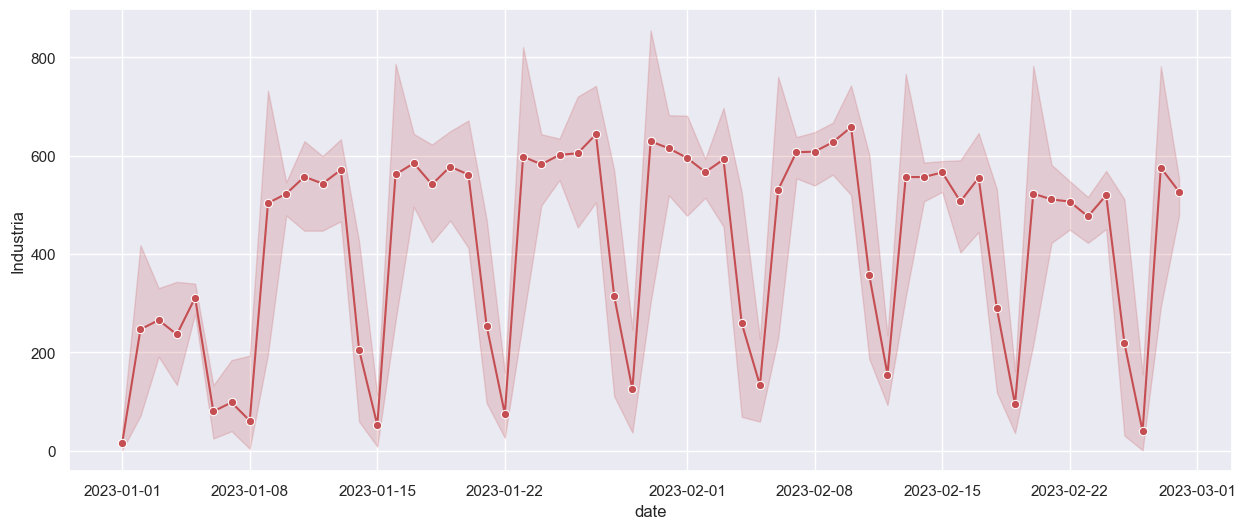

In [374]:
year = '2023'
months = ['01', '02']
sector = 'Industria'

fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(
    data=daily[daily.month.isin(months) & (daily.year==year)],
    x='date',
    y=sector,
    color=colors[3],
    errorbar='pi',
    ax=ax,
    marker='o'
)